In [26]:
import os
# from osgeo import gdal
import numpy as np
from skimage.io import imread, imsave
from pathlib import Path
import random
import matplotlib.pyplot as plt

In [27]:
fileName = "../data/processed/RGB.Copy.png"
img = imread(fileName)

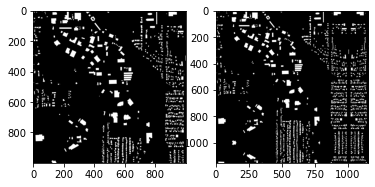

In [44]:
fileName = "../data/processed/GT.Copy.png"
img_gt= imread(fileName)
padded_img_gt = padding_image(img_gt, crop_size, stride)

plt.subplot(1, 2, 1)
plt.imshow(img_gt, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(padded_img_gt, cmap='gray')
plt.show()

In [54]:
save_path = "../data/processed/RGB"
new_name = 99
ext = '.png'
print(f"{save_path}/{new_name:04d}{ext}")

../data/processed/RGB/0099.png
